# Setting

In [1]:
import os
import gc
import random
import joblib
import pickle
from typing import List, Dict, Union

import numpy as np
from numba import njit
import polars as pl
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.metrics import map_at_k, ap_at_k

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
EXP_NAME = "exp208"
INPUT_DIR = "../../input/raw/"
CANDIDATES_DIR = "candidates/"
FEATURE_DIR = "features/"
LAST_NS = [1, 2, 3]
K_FOLDS = 5
SEED = 42

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(SEED)

In [4]:
LGBM_PARAMS = {
    "objective": "lambdarank",
    "metric": "map",
    "boosting": "dart",
    "seed": SEED,
    "num_leaves": 13,
    "max_depth": 7,
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
    "min_data_in_leaf": 30,
    "eval_at": [20],
    # "lambdarank_truncation_level" : 40,
    "deterministic":True,
}

In [5]:
train_log = pl.read_csv(os.path.join(INPUT_DIR, "train_log.csv"))
train_label = pl.read_csv(os.path.join(INPUT_DIR, "train_label.csv"))
test_log = pl.read_csv(os.path.join(INPUT_DIR, "test_log.csv"))
test_session = pl.read_csv(os.path.join(INPUT_DIR, "test_session.csv"))

In [6]:
co_visit_matrix_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "co_visit_matrix_for_train_or_eval.parquet"))
co_visit_matrix_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "co_visit_matrix_for_test.parquet"))

co_visit_matrix_trend_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "co_visit_matrix_trend_for_train_or_eval.parquet"))
co_visit_matrix_trend_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "co_visit_matrix_trend_for_test.parquet"))

already_clicked_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "already_clicked_for_train_or_eval.parquet"))
already_clicked_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "already_clicked_for_test.parquet"))

popular_yados_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_per_sml_cd_for_train_or_eval.parquet"))
popular_yados_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_per_sml_cd_for_test.parquet"))

popular_yados_trend_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_trend_per_sml_cd_for_train_or_eval.parquet"))
popular_yados_trend_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_trend_per_sml_cd_for_test.parquet"))

popular_yados_lrg_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_per_lrg_cd_for_train_or_eval.parquet"))
popular_yados_lrg_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_per_lrg_cd_for_test.parquet"))

popular_yados_trend_lrg_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_popular_yados_per_lrg_cd_for_train_or_eval.parquet"))
popular_yados_trend_lrg_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_popular_yados_per_lrg_cd_for_test.parquet"))

similar_yados = pl.read_parquet(os.path.join(CANDIDATES_DIR, "similar_yados.parquet"))

imf_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "imf_for_train_or_eval.parquet"))
imf_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "imf_for_test.parquet"))

trend_imf_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_imf_for_train_or_eval.parquet"))
trend_imf_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_imf_for_test.parquet"))

bpr_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "bpr_for_train_or_eval.parquet"))
bpr_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "bpr_for_test.parquet"))

trend_bpr_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_bpr_for_train_or_eval.parquet"))
trend_bpr_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_bpr_for_test.parquet"))

i2v_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "item2vec_for_train_or_eval.parquet"))
i2v_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "item2vec_for_test.parquet"))

In [7]:
class CandidateMatrix:
    def __init__(self, matrix: pl.DataFrame, feat_name: List[str], join_key: str):
        self.matrix = matrix
        self.feat_name = feat_name
        self.join_key = join_key

In [8]:
candidate_matrices_train =[
    CandidateMatrix(co_visit_matrix_train, ["co_visit_weight_rank"], "item"),
    CandidateMatrix(co_visit_matrix_trend_train, ["trend_co_visit_weight_rank"], "item"),
    CandidateMatrix(already_clicked_train, ["seq_no_inverse"], "session"),
    CandidateMatrix(popular_yados_train, ["popularity_rank"], "item"),
    CandidateMatrix(popular_yados_trend_train, ["trend_popularity_rank"], "item"),
    CandidateMatrix(popular_yados_lrg_train, ["popularity_rank_lrg"], "item"),
    CandidateMatrix(popular_yados_trend_lrg_train, ["trend_popularity_rank_lrg"], "item"),
    CandidateMatrix(similar_yados, ["nn_distance"], "item"),
    CandidateMatrix(imf_train, ["imf_rank"], "session"),
    CandidateMatrix(trend_imf_train, ["trend_imf_rank"], "session"),
    CandidateMatrix(i2v_train, ["i2v_rank"], "item"),
    CandidateMatrix(bpr_train, ["bpr_rank"], "session"),
    CandidateMatrix(trend_bpr_train, ["trend_bpr_rank"], "session"),
]

In [9]:
candidate_matrices_test =[
    CandidateMatrix(co_visit_matrix_test, ["co_visit_weight_rank"], "item"),
    CandidateMatrix(co_visit_matrix_trend_test, ["trend_co_visit_weight_rank"], "item"),
    CandidateMatrix(already_clicked_test, ["seq_no_inverse"], "session"),
    CandidateMatrix(popular_yados_test, ["popularity_rank"], "item"),
    CandidateMatrix(popular_yados_trend_test, ["trend_popularity_rank"], "item"),
    CandidateMatrix(popular_yados_lrg_test, ["popularity_rank_lrg"], "item"),
    CandidateMatrix(popular_yados_trend_lrg_test, ["trend_popularity_rank_lrg"], "item"),
    CandidateMatrix(similar_yados, ["nn_distance"], "item"),
    CandidateMatrix(imf_test, ["imf_rank"], "session"),
    CandidateMatrix(trend_imf_test, ["trend_imf_rank"], "session"),
    CandidateMatrix(i2v_test, ["i2v_rank"], "item"),
    CandidateMatrix(bpr_test, ["bpr_rank"], "session"),
    CandidateMatrix(trend_bpr_test, ["trend_bpr_rank"], "session"),
]

In [10]:
session_feat_train = pl.read_parquet(os.path.join(FEATURE_DIR, "session_feat_for_train_or_eval.parquet"))
session_feat_test = pl.read_parquet(os.path.join(FEATURE_DIR, "session_feat_for_test.parquet"))
product_feat_train = pl.read_parquet(os.path.join(FEATURE_DIR, "product_feat_train.parquet"))
product_feat_test = pl.read_parquet(os.path.join(FEATURE_DIR, "product_feat_test.parquet"))
session_product_feat_train = pl.read_parquet(os.path.join(FEATURE_DIR, "session_product_feat_for_train_or_eval.parquet"))
session_product_feat_test = pl.read_parquet(os.path.join(FEATURE_DIR, "session_product_feat_for_test.parquet"))

In [11]:
# i2v
i2v_model_train = Word2Vec.load(os.path.join(FEATURE_DIR, "item2vec_for_train_or_eval.model"))
i2v_model_test = Word2Vec.load(os.path.join(FEATURE_DIR, "item2vec_for_test.model"))

In [12]:
# imf
imf_model_train = np.load(os.path.join(FEATURE_DIR, "imf_model_for_train_or_eval.npz"))
with open(os.path.join(FEATURE_DIR, "imf_user_id2index_for_train_or_eval.pickle"), "rb") as f:
    user_id2index_train = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "imf_item_id2index_for_train_or_eval.pickle"), "rb") as f:
    item_id2index_train = pickle.load(f)

imf_model_test = np.load(os.path.join(FEATURE_DIR, "imf_model_for_test.npz"))
with open(os.path.join(FEATURE_DIR, "imf_user_id2index_for_test.pickle"), "rb") as f:
    user_id2index_test = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "imf_item_id2index_for_test.pickle"), "rb") as f:
    item_id2index_test = pickle.load(f)

trend_imf_model_train = np.load(os.path.join(FEATURE_DIR, "trend_imf_model_for_train_or_eval.npz"))
with open(os.path.join(FEATURE_DIR, "trend_imf_user_id2index_for_train_or_eval.pickle"), "rb") as f:
    trend_user_id2index_train = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "trend_imf_item_id2index_for_train_or_eval.pickle"), "rb") as f:
    trend_item_id2index_train = pickle.load(f)

trend_imf_model_test = np.load(os.path.join(FEATURE_DIR, "trend_imf_model_for_test.npz"))
with open(os.path.join(FEATURE_DIR, "trend_imf_user_id2index_for_test.pickle"), "rb") as f:
    trend_user_id2index_test = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "trend_imf_item_id2index_for_test.pickle"), "rb") as f:
    trend_item_id2index_test = pickle.load(f)

In [13]:
# bpr
bpr_model_train = np.load(os.path.join(FEATURE_DIR, "bpr_model_for_train_or_eval.npz"))
with open(os.path.join(FEATURE_DIR, "bpr_user_id2index_for_train_or_eval.pickle"), "rb") as f:
    bpr_user_id2index_train = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "bpr_item_id2index_for_train_or_eval.pickle"), "rb") as f:
    bpr_item_id2index_train = pickle.load(f)

bpr_model_test = np.load(os.path.join(FEATURE_DIR, "bpr_model_for_test.npz"))
with open(os.path.join(FEATURE_DIR, "bpr_user_id2index_for_test.pickle"), "rb") as f:
    bpr_user_id2index_test = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "bpr_item_id2index_for_test.pickle"), "rb") as f:
    bpr_item_id2index_test = pickle.load(f)

trend_bpr_model_train = np.load(os.path.join(FEATURE_DIR, "trend_bpr_model_for_train_or_eval.npz"))
with open(os.path.join(FEATURE_DIR, "trend_bpr_user_id2index_for_train_or_eval.pickle"), "rb") as f:
    trend_bpr_user_id2index_train = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "trend_bpr_item_id2index_for_train_or_eval.pickle"), "rb") as f:
    trend_bpr_item_id2index_train = pickle.load(f)

trend_bpr_model_test = np.load(os.path.join(FEATURE_DIR, "trend_bpr_model_for_test.npz"))
with open(os.path.join(FEATURE_DIR, "trend_bpr_user_id2index_for_test.pickle"), "rb") as f:
    trend_bpr_user_id2index_test = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "trend_bpr_item_id2index_for_test.pickle"), "rb") as f:
    trend_bpr_item_id2index_test = pickle.load(f)

In [14]:
def generate_candidates(df: pl.DataFrame, candidate_matrices:List[CandidateMatrix]) -> pl.DataFrame:

    def add_last_n_item(df: pl.DataFrame, last_n: int) -> pl.DataFrame:
        last_item_list = []
        prev_items_list = df["prev_items"].to_list()
        for prev_items in prev_items_list:
            try:
                last_item_list.append(prev_items[-last_n])
            except IndexError:
                last_item_list.append(None)
        df = df.with_columns(pl.Series(name=f"last_yad_no_{last_n}", values=last_item_list))
        return df

    # add last_item columns
    for last_n in LAST_NS:
        df = add_last_n_item(df, last_n)

    # generate candidates
    candidates = []

    # candidates tied to items
    for last_n in LAST_NS:
        for candidate_matrix in candidate_matrices:
            if candidate_matrix.join_key == "item":        
                # join candidates to last_n item
                candidate = df.join(candidate_matrix.matrix, left_on=f"last_yad_no_{last_n}", right_on="yad_no", how="left")
                candidate = candidate.filter(pl.col("last_yad_no_1") != pl.col("candidate_yad_no")) # remove last click yado
                
                # keep candidates for feature addition later
                features_original = candidate_matrix.feat_name
                features = [f"{x}_last{last_n}" for x in features_original]
                tmp = candidate[["session_id", "candidate_yad_no"] + features_original]
                for feature, feature_original in zip(features, features_original):
                    tmp = tmp.rename({feature_original:feature})
                candidates.append(tmp)

    # candidates tied to session
    for candidate_matrix in candidate_matrices:
        if candidate_matrix.join_key == "session":
            candidate = df.join(candidate_matrix.matrix, on="session_id", how="left")
            candidate = candidate.filter(pl.col("last_yad_no_1") != pl.col("candidate_yad_no")) # remove last click yado
            candidates.append(candidate[["session_id", "candidate_yad_no"] + candidate_matrix.feat_name])

    # concatenate candidates
    cand_all = pl.concat([df[["session_id", "candidate_yad_no"]] for df in candidates])

    # remove duplicate candidates
    cand_all = cand_all.unique(subset=["session_id", "candidate_yad_no"])

    # join candidates
    df = df.join(cand_all, on=["session_id"], how="left")

    # add features derived from the candidate
    for candidate in candidates:
        df = df.join(candidate, on=["session_id", "candidate_yad_no"], how="left")

    return df

In [15]:
def add_label(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns((pl.col("candidate_yad_no") == pl.col("label")).cast(pl.Int8).alias("label"))
    return df

In [16]:
def filter_null(df: pl.DataFrame, candidate_matrices:List[CandidateMatrix]) -> pl.DataFrame:
    feat_names = []
    for candidate_matrix in candidate_matrices:
        if candidate_matrix.join_key == "item":
            for last_n in LAST_NS:
                for feat_name in candidate_matrix.feat_name:
                    feat_names.append(f"{feat_name}_last{last_n}")
        elif candidate_matrix.join_key == "session":
            feat_names.extend(candidate_matrix.feat_name)
    
    df = df.filter(
        ~pl.all_horizontal(pl.col(feat_names).is_null())
    )
    
    return df

In [17]:
def filter_session_not_include_positive(df: pl.DataFrame) -> pl.DataFrame:
    positive_sessions = df.filter(pl.col("label")==1)["session_id"].to_list()
    df = df.filter(df["session_id"].is_in(positive_sessions))
    return df

In [18]:
def negative_sample(df: pl.DataFrame) -> pl.DataFrame:
    negatives = df.filter(df["label"] == 0)
    negatives = negatives.sample(fraction=0.075, seed=SEED)
    df = pl.concat([df.filter(df["label"] > 0), negatives])
    return df

In [19]:
def add_features(
    df: pl.DataFrame, 
    session_feat_df:pl.DataFrame, product_feat_df:pl.DataFrame, session_product_feat_df:pl.DataFrame,
    i2v_model,
    imf_model, user_id2index, item_id2index,
    trend_imf_model, trend_user_id2index, trend_item_id2index,
    bpr_model, bpr_user_id2index, bpr_item_id2index,
    trend_bpr_model, trend_bpr_user_id2index, trend_bpr_item_id2index,
) -> pl.DataFrame:

    ### session features
    df = df.join(session_feat_df, on="session_id", how="left")

    ### product features
    df = df.join(product_feat_df, left_on="candidate_yad_no", right_on="yad_no", how="left")

    ### session * product features
    df = df.join(session_product_feat_df, left_on=["session_id", "candidate_yad_no"], right_on=["session_id", "yad_no"], how="left")

    # item2item similality
    for last_n in LAST_NS:
        df = df.with_columns([
            ((pl.col("P_wireless_lan_flg") == pl.col(f"S_wireless_lan_flg_last{last_n}"))&(pl.col(f"S_wireless_lan_flg_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_lan_flg_last{last_n}"),
            ((pl.col("P_onsen_flg") == pl.col(f"S_onsen_flg_last{last_n}"))&(pl.col(f"S_onsen_flg_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_onsen_flg_last{last_n}"),
            ((pl.col("P_kd_stn_5min") == pl.col(f"S_kd_stn_5min_last{last_n}"))&(pl.col(f"S_kd_stn_5min_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_kd_stn_5min_last{last_n}"),
            ((pl.col("P_kd_bch_5min") == pl.col(f"S_kd_bch_5min_last{last_n}"))&(pl.col(f"S_kd_bch_5min_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_kd_bch_5min_last{last_n}"),
            ((pl.col("P_kd_slp_5min") == pl.col(f"S_kd_slp_5min_last{last_n}"))&(pl.col(f"S_kd_slp_5min_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_kd_slp_5min_last{last_n}"),
            ((pl.col("P_kd_conv_walk_5min") == pl.col(f"S_kd_conv_walk_5min_last{last_n}"))&(pl.col(f"S_kd_conv_walk_5min_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_kd_conv_walk_5min_last{last_n}"),
            ((pl.col("P_wid_cd") == pl.col(f"S_wid_cd_last{last_n}"))&(pl.col(f"S_wid_cd_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_wid_cd_last{last_n}"),
            ((pl.col("P_ken_cd") == pl.col(f"S_ken_cd_last{last_n}"))&(pl.col(f"S_ken_cd_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_ken_cd_last{last_n}"),
            ((pl.col("P_lrg_cd") == pl.col(f"S_lrg_cd_last{last_n}"))&(pl.col(f"S_lrg_cd_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_lrg_cd_last{last_n}"),
            ((pl.col("P_sml_cd") == pl.col(f"S_sml_cd_last{last_n}"))&(pl.col(f"S_sml_cd_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_sml_cd_last{last_n}"),
        ])

    for last_n in LAST_NS:
        df = df.with_columns(
            pl.sum_horizontal(
                f"SP_same_lan_flg_last{last_n}", 
                f"SP_same_onsen_flg_last{last_n}", 
                f"SP_same_kd_stn_5min_last{last_n}", 
                f"SP_same_kd_bch_5min_last{last_n}", 
                f"SP_same_kd_slp_5min_last{last_n}", 
                f"SP_same_kd_conv_walk_5min_last{last_n}", 
                f"SP_same_wid_cd_last{last_n}", 
                f"SP_same_ken_cd_last{last_n}", 
                f"SP_same_lan_flg_last{last_n}", 
                f"SP_same_lrg_cd_last{last_n}", 
            )
            .alias(f"SP_item2item_similarity_last{last_n}")
        )
    df = df.with_columns(
        df[[f"SP_item2item_similarity_last{last_n}" for last_n in LAST_NS]].mean(axis=1).alias(f"SP_item2item_similarity")
    )
    df = df.with_columns(
        (pl.col("P_total_room_cnt") - pl.col("S_mean_room_cnt")).alias("SP_diff_room_cnt")
    )

    # i2v similarity
    for last_n in LAST_NS:
        last_items = df[f"last_yad_no_{last_n}"].to_list()
        cand_items = df["candidate_yad_no"].to_list()
        item_similalities = []
        for last_item, cand_item in zip(last_items, cand_items):
            try:
                sim = i2v_model.wv.similarity(last_item, cand_item)
            except (KeyError, TypeError): # KeyError if the item is not in the item2vec training data. TypeError if there are no candidates in a session.
                sim = -1
            item_similalities.append(np.float32(sim))
        df = df.with_columns(pl.Series(name=f"i2v_similarity_last{last_n}", values=item_similalities).cast(pl.Float32))
    df = df.with_columns(
        (pl.col("i2v_similarity_last1") + pl.col("i2v_similarity_last2") + pl.col("i2v_similarity_last3")) \
        .mean() \
        .alias("i2v_similarity_mean")
    )
        
    # session2item similarity
    @njit()
    def calc_cos_sim(v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

    sessions = df["session_id"].to_list()
    candidates = df["candidate_yad_no"].to_list()
    user_index2vector = dict(enumerate(imf_model["user_factors"]))
    item_index2vector = dict(enumerate(imf_model["item_factors"]))
    imf_similarities = []
    for session, candidate in zip(sessions, candidates):
        try:
            user_index, item_index = user_id2index[session], item_id2index[candidate]
            v1, v2 = user_index2vector[user_index], item_index2vector[item_index]
            sim = calc_cos_sim(v1, v2)
        except (KeyError, TypeError): # KeyError if the item is not in the imf training data. TypeError if there are no candidates in a session.
            sim = -1
        imf_similarities.append(np.float32(sim))
    df = df.with_columns(pl.Series(name="imf_similarity", values=imf_similarities).cast(pl.Float32))

    sessions = df["session_id"].to_list()
    candidates = df["candidate_yad_no"].to_list()
    user_index2vector = dict(enumerate(trend_imf_model["user_factors"]))
    item_index2vector = dict(enumerate(trend_imf_model["item_factors"]))
    imf_similarities = []
    for session, candidate in zip(sessions, candidates):
        try:
            user_index, item_index = trend_user_id2index[session], trend_item_id2index[candidate]
            v1, v2 = user_index2vector[user_index], item_index2vector[item_index]
            sim = calc_cos_sim(v1, v2)
        except (KeyError, TypeError): # KeyError if the item is not in the imf training data. TypeError if there are no candidates in a session.
            sim = -1
        imf_similarities.append(np.float32(sim))
    df = df.with_columns(pl.Series(name="trend_imf_similarity", values=imf_similarities).cast(pl.Float32))

    # bpr
    sessions = df["session_id"].to_list()
    candidates = df["candidate_yad_no"].to_list()
    user_index2vector = dict(enumerate(bpr_model["user_factors"]))
    item_index2vector = dict(enumerate(bpr_model["item_factors"]))
    imf_similarities = []
    for session, candidate in zip(sessions, candidates):
        try:
            user_index, item_index = bpr_user_id2index[session], bpr_item_id2index[candidate]
            v1, v2 = user_index2vector[user_index], item_index2vector[item_index]
            sim = calc_cos_sim(v1, v2)
        except (KeyError, TypeError): # KeyError if the item is not in the imf training data. TypeError if there are no candidates in a session.
            sim = -1
        imf_similarities.append(np.float32(sim))
    df = df.with_columns(pl.Series(name="bpr_similarity", values=imf_similarities).cast(pl.Float32))

    sessions = df["session_id"].to_list()
    candidates = df["candidate_yad_no"].to_list()
    user_index2vector = dict(enumerate(trend_bpr_model["user_factors"]))
    item_index2vector = dict(enumerate(trend_bpr_model["item_factors"]))
    imf_similarities = []
    for session, candidate in zip(sessions, candidates):
        try:
            user_index, item_index = trend_bpr_user_id2index[session], trend_bpr_item_id2index[candidate]
            v1, v2 = user_index2vector[user_index], item_index2vector[item_index]
            sim = calc_cos_sim(v1, v2)
        except (KeyError, TypeError): # KeyError if the item is not in the imf training data. TypeError if there are no candidates in a session.
            sim = -1
        imf_similarities.append(np.float32(sim))
    df = df.with_columns(pl.Series(name="trend_bpr_similarity", values=imf_similarities).cast(pl.Float32))

    return df

In [20]:
def fill_null_and_cast(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns([
        pl.col("co_visit_weight_rank_last1").fill_null(999).cast(pl.Float32),
        pl.col("co_visit_weight_rank_last2").fill_null(999).cast(pl.Float32),
        pl.col("co_visit_weight_rank_last3").fill_null(999).cast(pl.Float32),
        pl.col("trend_co_visit_weight_rank_last1").fill_null(999).cast(pl.Float32),
        pl.col("trend_co_visit_weight_rank_last2").fill_null(999).cast(pl.Float32),
        pl.col("trend_co_visit_weight_rank_last3").fill_null(999).cast(pl.Float32),
        pl.col("popularity_rank_last1").fill_null(999).cast(pl.Float32),
        pl.col("popularity_rank_last2").fill_null(999).cast(pl.Float32),
        pl.col("popularity_rank_last3").fill_null(999).cast(pl.Float32),
        pl.col("trend_popularity_rank_last1").fill_null(999).cast(pl.Float32),
        pl.col("trend_popularity_rank_last2").fill_null(999).cast(pl.Float32),
        pl.col("trend_popularity_rank_last3").fill_null(999).cast(pl.Float32),
        pl.col("popularity_rank_lrg_last1").fill_null(999).cast(pl.Float32),
        pl.col("popularity_rank_lrg_last2").fill_null(999).cast(pl.Float32),
        pl.col("popularity_rank_lrg_last3").fill_null(999).cast(pl.Float32),
        pl.col("trend_popularity_rank_lrg_last1").fill_null(999).cast(pl.Float32),
        pl.col("trend_popularity_rank_lrg_last2").fill_null(999).cast(pl.Float32),
        pl.col("trend_popularity_rank_lrg_last3").fill_null(999).cast(pl.Float32),
        pl.col("nn_distance_last1").fill_null(999).cast(pl.Float32),
        pl.col("nn_distance_last2").fill_null(999).cast(pl.Float32),
        pl.col("nn_distance_last3").fill_null(999).cast(pl.Float32),
        pl.col("i2v_rank_last1").fill_null(999).cast(pl.Float32),
        pl.col("i2v_rank_last2").fill_null(999).cast(pl.Float32),
        pl.col("i2v_rank_last3").fill_null(999).cast(pl.Float32),
        pl.col("seq_no_inverse").fill_null(999).cast(pl.Int16),
        pl.col("imf_rank").fill_null(999).cast(pl.Int16),
        pl.col("trend_imf_rank").fill_null(999).cast(pl.Int16),
        pl.col("bpr_rank").fill_null(999).cast(pl.Float32),
        pl.col("trend_bpr_rank").fill_null(999).cast(pl.Float32),
        pl.col("SP_interact_count").fill_null(0).cast(pl.Int16),
    ])
    return df

In [21]:
def predict(df:pl.DataFrame, chunk_size:int=30_000_000) -> np.array:
    preds = np.zeros((df.shape[0],))
    for fold in range(K_FOLDS):
        # load model
        model = pickle.load(open(f'../../model/lgb_{EXP_NAME}_{fold+1}.pkl', "rb"))
        # chunk data and predict to prevent OOM
        preds_by_one_model = []
        for frame in df.iter_slices(n_rows=chunk_size):
            preds_chunk = model.predict(frame[FEATURES].to_pandas(), num_iteration=model.best_iteration)
            preds_by_one_model.append(preds_chunk)
        preds += np.concatenate(preds_by_one_model)
    preds /= K_FOLDS
    return preds

# Process train data

In [22]:
original_train_log = train_log.clone()
original_train_label = train_label.clone()

In [23]:
prev_items_list = (
    train_log
    .sort(["session_id", "seq_no"])
    .group_by("session_id", maintain_order=True)
    .agg(pl.col("yad_no"))
)["yad_no"].to_list()

train = train_label.with_columns(
    pl.Series(name="prev_items", values=prev_items_list)
).rename(
    {"yad_no":"label"}
)

In [24]:
train = generate_candidates(train, candidate_matrices_train)
train = train.drop("prev_items")
train = add_label(train)
train = filter_null(train, candidate_matrices_train)
train = filter_session_not_include_positive(train)
train = negative_sample(train)
train = add_features(
    train, 
    session_feat_train, product_feat_train, session_product_feat_train, 
    i2v_model_train,
    imf_model_train, user_id2index_train, item_id2index_train,
    trend_imf_model_train, trend_user_id2index_train, trend_item_id2index_train,
    bpr_model_train, bpr_user_id2index_train, bpr_item_id2index_train,
    trend_bpr_model_train, trend_bpr_user_id2index_train, trend_bpr_item_id2index_train,
)
train = fill_null_and_cast(train)

# Train model

In [25]:
not_use_col = [
    "session_id",
    "label",
    "last_yad_no_1",
    "last_yad_no_2",
    "last_yad_no_3",
    "candidate_yad_no",
    "P_wid_cd", "P_ken_cd", "P_lrg_cd", "P_sml_cd",
    "S_wid_cd_last1", "S_wid_cd_last2", "S_wid_cd_last3",
    "S_ken_cd_last1", "S_ken_cd_last2", "S_ken_cd_last3",
    "S_lrg_cd_last1", "S_lrg_cd_last2", "S_lrg_cd_last3",
    "S_sml_cd_last1", "S_sml_cd_last2", "S_sml_cd_last3",
]
FEATURES = [col for col in train.columns if col not in not_use_col]

In [26]:
train = train[["session_id", "candidate_yad_no", "label"] + FEATURES]

In [27]:
train = train.to_pandas()

In [28]:
# https://qiita.com/birdwatcher/items/78e0158957fec2d6c9e8
class DartEarlyStopping(object):
    """DartEarlyStopping"""

    def __init__(self, data_name, monitor_metric, stopping_round):
        self.data_name = data_name
        self.monitor_metric = monitor_metric
        self.stopping_round = stopping_round
        self.best_score = None
        self.best_model = None
        self.best_score_list = []
        self.best_iter = 0

    def _is_higher_score(self, metric_score, is_higher_better):
        if self.best_score is None:
            return True
        return (self.best_score < metric_score) if is_higher_better else (self.best_score > metric_score)

    def _deepcopy(self, x):
        # copy.deepcopyではlightgbmのモデルは完全にコピーされないためpickleを使用
        return pickle.loads(pickle.dumps(x))

    def __call__(self, env):
        evals = env.evaluation_result_list
        for data, metric, score, is_higher_better in evals:
            if data != self.data_name or metric != self.monitor_metric:
                continue
            if not self._is_higher_score(score, is_higher_better):
                if env.iteration - self.best_iter > self.stopping_round:
                    # 終了させる
                    eval_result_str = '\t'.join([lgb.callback._format_eval_result(x) for x in self.best_score_list])
                    lgb.basic._log_info(f"Early stopping, best iteration is:\n[{self.best_iter+1}]\t{eval_result_str}") 
                    lgb.basic._log_info(f"You can get best model by \"DartEarlyStopping.best_model\"")
                    raise lgb.callback.EarlyStopException(self.best_iter, self.best_score_list)
                return
            # dartでは過去の木も更新されてしまうため、deepcopyしておく
            self.best_model = self._deepcopy(env.model)
            self.best_iter = env.iteration
            self.best_score_list = evals
            self.best_score = score
            return
        raise ValueError("monitoring metric not found")

In [29]:
%%time
feat_imp = np.zeros((len(FEATURES),))
oof_predictions = []
gkf = GroupKFold(n_splits=K_FOLDS)
for fold, (train_idx, val_idx) in enumerate(gkf.split(train, train["label"], groups=train["session_id"])):
    print(f'======= Fold {fold+1}=======')

    # Split data into train and validation sets
    train_tmp = train.iloc[train_idx].copy()
    valid_tmp = train.iloc[val_idx].copy()
    train_tmp.sort_values("session_id", inplace=True)
    valid_tmp.sort_values("session_id", inplace=True)
    train_baskets = train_tmp.groupby("session_id")["candidate_yad_no"].count().values
    valid_baskets = valid_tmp.groupby("session_id")["candidate_yad_no"].count().values
    X_train, y_train = train_tmp[FEATURES], train_tmp["label"]
    X_val, y_val = valid_tmp[FEATURES], valid_tmp["label"]

    # Create LightGBM dataset
    lgb_train = lgb.Dataset(X_train, y_train, group=train_baskets)
    lgb_val = lgb.Dataset(X_val, y_val, group=valid_baskets, reference=lgb_train)

    # Train LightGBM model
    des = DartEarlyStopping("valid_1", "map@20", 100)
    model = lgb.train(LGBM_PARAMS,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=[lgb_train, lgb_val],
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=100),
                        lgb.log_evaluation(25),
                        des,
                    ]
            )
    model = des.best_model
    
    # Save LightGBM model
    joblib.dump(model, f'../../model/lgb_{EXP_NAME}_{fold+1}.pkl')

    # Add feature importance scores
    feat_imp += model.feature_importance(importance_type="gain")

    # Predict oof
    valid_sessions = list(valid_tmp["session_id"].unique())
    valid_log = original_train_log.filter(pl.col("session_id").is_in(valid_sessions))
    valid_label = original_train_label.filter(pl.col("session_id").is_in(valid_sessions))
    
    prev_items_list = (
        valid_log
        .sort(["session_id", "seq_no"])
        .group_by("session_id", maintain_order=True)
        .agg(pl.col("yad_no"))
    )["yad_no"].to_list()
    
    valid = valid_label.with_columns(
        pl.Series(name="prev_items", values=prev_items_list)
    ).rename(
        {"yad_no":"label"}
    )

    valid = generate_candidates(valid, candidate_matrices_train)
    valid = valid.drop("prev_items")
    valid = add_features(
        valid, 
        session_feat_train, product_feat_train, session_product_feat_train, 
        i2v_model_train,
        imf_model_train, user_id2index_train, item_id2index_train,
        trend_imf_model_train, trend_user_id2index_train, trend_item_id2index_train,
        bpr_model_train, bpr_user_id2index_train, bpr_item_id2index_train,
        trend_bpr_model_train, trend_bpr_user_id2index_train, trend_bpr_item_id2index_train,
    )
    valid = fill_null_and_cast(valid)

    model = pickle.load(open(f'../../model/lgb_{EXP_NAME}_{fold+1}.pkl', "rb"))
    preds = model.predict(valid[FEATURES].to_pandas(), num_iteration=model.best_iteration)
    valid = valid.with_columns(pl.Series(name="pred", values=preds))    
    # valid = valid[["session_id", "candidate_yad_no", "pred", "label"]]
    valid = valid.sort(["session_id", "pred"], descending=[False, True])
    oof_prediction = valid.group_by("session_id", maintain_order=True).head(10)
    oof_predictions.append(oof_prediction)

oof_prediction = pl.concat(oof_predictions)
oof_prediction = oof_prediction.with_columns((pl.col("candidate_yad_no") == pl.col("label")).cast(pl.Int8).alias("user_relevance")).fill_null(0)
user_relevances = oof_prediction.group_by("session_id", maintain_order=True).all()["user_relevance"].to_list()
print(f'======= Training Done =======')
total_num_session = original_train_log["session_id"].n_unique()
print("map@10:", float(np.sum([ap_at_k(user_relevances, 10) for user_relevances in user_relevances]) / total_num_session))
print(f'=============================')

======= Fold 1=======
[LightGBM] [Info] Total groups: 195695, total data: 898078
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7141
[LightGBM] [Info] Number of data points in the train set: 898078, number of used features: 120
[LightGBM] [Info] Total groups: 48924, total data: 224520


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[25]	training's map@20: 0.822583	valid_1's map@20: 0.821421
[50]	training's map@20: 0.823334	valid_1's map@20: 0.822356
[75]	training's map@20: 0.823809	valid_1's map@20: 0.822336
[100]	training's map@20: 0.824068	valid_1's map@20: 0.822347
[125]	training's map@20: 0.824193	valid_1's map@20: 0.822243
[150]	training's map@20: 0.824364	valid_1's map@20: 0.822371
[175]	training's map@20: 0.82435	valid_1's map@20: 0.822672
[200]	training's map@20: 0.824684	valid_1's map@20: 0.822525
[225]	training's map@20: 0.824714	valid_1's map@20: 0.8226
[250]	training's map@20: 0.825122	valid_1's map@20: 0.822351
[275]	training's map@20: 0.825265	valid_1's map@20: 0.822051
Early stopping, best iteration is:
[183]	training's map@20: 0.82458	valid_1's map@20: 0.822735
You can get best model by "DartEarlyStopping.best_model"
======= Fold 2=======
[LightGBM] [Info] Total groups: 195695, total data: 898078
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086692 seco

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[25]	training's map@20: 0.821999	valid_1's map@20: 0.821763
[50]	training's map@20: 0.823225	valid_1's map@20: 0.822561
[75]	training's map@20: 0.823673	valid_1's map@20: 0.822639
[100]	training's map@20: 0.823984	valid_1's map@20: 0.82281
[125]	training's map@20: 0.824007	valid_1's map@20: 0.822855
[150]	training's map@20: 0.824227	valid_1's map@20: 0.823098
[175]	training's map@20: 0.824242	valid_1's map@20: 0.823277
[200]	training's map@20: 0.824465	valid_1's map@20: 0.823399
[225]	training's map@20: 0.824746	valid_1's map@20: 0.823412
[250]	training's map@20: 0.824926	valid_1's map@20: 0.823571
[275]	training's map@20: 0.825246	valid_1's map@20: 0.823412
[300]	training's map@20: 0.825496	valid_1's map@20: 0.823718
[325]	training's map@20: 0.825748	valid_1's map@20: 0.823732
[350]	training's map@20: 0.825981	valid_1's map@20: 0.823783
[375]	training's map@20: 0.826046	valid_1's map@20: 0.823891
[400]	training's map@20: 0.826183	valid_1's map@20: 0.823759
[425]	training's map@20: 0.8

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[25]	training's map@20: 0.821924	valid_1's map@20: 0.82281
[50]	training's map@20: 0.822835	valid_1's map@20: 0.823656
[75]	training's map@20: 0.823235	valid_1's map@20: 0.824034
[100]	training's map@20: 0.823447	valid_1's map@20: 0.82419
[125]	training's map@20: 0.823633	valid_1's map@20: 0.824046
[150]	training's map@20: 0.823822	valid_1's map@20: 0.824052
[175]	training's map@20: 0.823858	valid_1's map@20: 0.82395
[200]	training's map@20: 0.82413	valid_1's map@20: 0.823977
[225]	training's map@20: 0.824254	valid_1's map@20: 0.823831
Early stopping, best iteration is:
[144]	training's map@20: 0.82364	valid_1's map@20: 0.824339
You can get best model by "DartEarlyStopping.best_model"
======= Fold 4=======
[LightGBM] [Info] Total groups: 195696, total data: 898079
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.655770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[25]	training's map@20: 0.822325	valid_1's map@20: 0.821264
[50]	training's map@20: 0.823364	valid_1's map@20: 0.822271
[75]	training's map@20: 0.823754	valid_1's map@20: 0.822302
[100]	training's map@20: 0.824118	valid_1's map@20: 0.822164
[125]	training's map@20: 0.824159	valid_1's map@20: 0.822138
[150]	training's map@20: 0.824643	valid_1's map@20: 0.822065
Early stopping, best iteration is:
[73]	training's map@20: 0.823694	valid_1's map@20: 0.822598
You can get best model by "DartEarlyStopping.best_model"
======= Fold 5=======
[LightGBM] [Info] Total groups: 195695, total data: 898079
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.962179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7146
[LightGBM] [Info] Number of data points in the train set: 898079, number of used features: 120
[LightGBM] [Info] Total groups: 48924, total d

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[25]	training's map@20: 0.822887	valid_1's map@20: 0.820552
[50]	training's map@20: 0.823704	valid_1's map@20: 0.821353
[75]	training's map@20: 0.824133	valid_1's map@20: 0.821069
[100]	training's map@20: 0.824277	valid_1's map@20: 0.82128
[125]	training's map@20: 0.824405	valid_1's map@20: 0.821327
[150]	training's map@20: 0.824626	valid_1's map@20: 0.821535
[175]	training's map@20: 0.824704	valid_1's map@20: 0.821676
[200]	training's map@20: 0.824914	valid_1's map@20: 0.821641
[225]	training's map@20: 0.825161	valid_1's map@20: 0.821765
[250]	training's map@20: 0.825479	valid_1's map@20: 0.821968
[275]	training's map@20: 0.825697	valid_1's map@20: 0.821704
[300]	training's map@20: 0.825912	valid_1's map@20: 0.821762
[325]	training's map@20: 0.826245	valid_1's map@20: 0.821414
[350]	training's map@20: 0.826461	valid_1's map@20: 0.821551
Early stopping, best iteration is:
[250]	training's map@20: 0.825479	valid_1's map@20: 0.821968
You can get best model by "DartEarlyStopping.best_mode

[Text(0.5, 1.0, 'Feature Importance TOP25')]

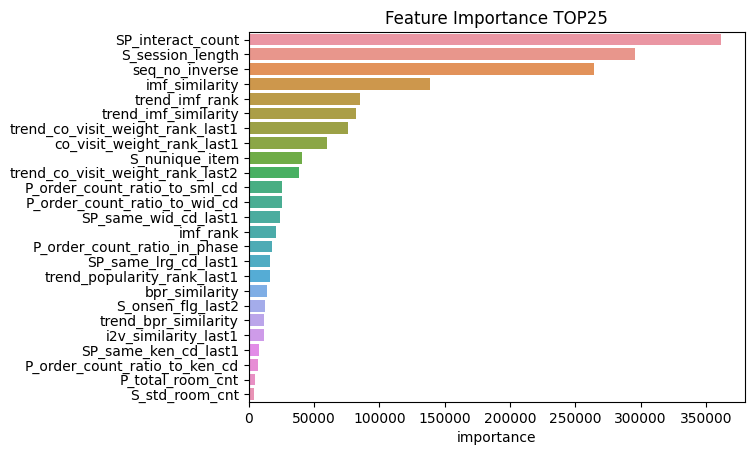

In [30]:
# visualize feature importances
fi_df = pd.DataFrame(index=FEATURES)
fi_df["importance"] = feat_imp / K_FOLDS
fi_df = fi_df.sort_values(by="importance", ascending=False).head(25)
sns.barplot(x="importance", y=fi_df.index, data=fi_df).set(title="Feature Importance TOP25")

# Prediction

In [31]:
prev_items_list = (
    test_log
    .sort(["session_id", "seq_no"])
    .group_by("session_id", maintain_order=True)
    .agg(pl.col("yad_no"))
)["yad_no"].to_list()

test = test_session.with_columns(
    pl.Series(name="prev_items", values=prev_items_list)
)

In [32]:
test = generate_candidates(test, candidate_matrices_test)
test = test.drop("prev_items")
test = add_features(
    test, 
    session_feat_test, product_feat_test, session_product_feat_test, 
    i2v_model_test,
    imf_model_test, user_id2index_test, item_id2index_test,
    trend_imf_model_test, trend_user_id2index_test, trend_item_id2index_test,
    bpr_model_test, bpr_user_id2index_test, bpr_item_id2index_test,
    trend_bpr_model_test, trend_bpr_user_id2index_test, trend_bpr_item_id2index_test,
)
test = fill_null_and_cast(test)

In [33]:
# prediction

def create_submit_file(pred, test_session, file_name, head_n=10):
    pred = pred.sort(["session_id", "pred"], descending=[False, True])
    prediction = pred.group_by("session_id", maintain_order=True).head(head_n)
    
    col_map = {}
    for i in range(0, head_n):
        col_map[f"{i}"] = f"predict_{i}"   
    prediction = prediction.with_columns(
        prediction.select(pl.col("session_id").cumcount().over("session_id").alias("pred_num"))
    )
    prediction = prediction.pivot(
        index="session_id",
        columns = "pred_num",
        values = "candidate_yad_no",
    ).rename(col_map)
    prediction = test_session.join(prediction, on="session_id", how="left")
    prediction = prediction.fill_null(0)
    prediction.drop("session_id").write_csv(file_name)

test = test.with_columns(
    pl.Series(name="pred", values=predict(test))
)

# for submit
file_name = f"../../output/{EXP_NAME}.csv"
create_submit_file(test, test_session, file_name, 10)

# for ensamble
file_name = f"../../output/{EXP_NAME}_for_ensamble.csv"
create_submit_file(test, test_session, file_name, 15)

# visualize

In [34]:
# cols = FEATURES + ["pred"]

In [35]:
# for col in cols:
#     fig, ax = plt.subplots()

#     x1 = valid[col]
#     x2 = test[col]

#     # 最大値と最小値の間をn_bin等分した幅でヒストグラムの棒を表示するように設定（各targetのbin幅を統一する）
#     n_bin = 20
#     if col.startswith("co_visit_weight"):
#         x_max = 100
#         x_min = 0
#     elif col.startswith("popularity"):
#         x_max = 10
#         x_min = 0
#     elif col == "seq_no_inverse":
#         x_max = 10
#         x_min = 0
#     elif col == "imf_rank":
#         x_max = 10
#         x_min = 0
#     else:
#         x_max = max(valid[col].max(), test[col].max())
#         x_min = min(valid[col].min(), test[col].min())
#     bins = np.linspace(x_min, x_max, n_bin)

#     ax.hist(x1, density=True, bins=bins, color="red", alpha=0.5, label="valid")
#     ax.hist(x2, density=True, bins=bins, color="blue", alpha=0.5, label="test")
#     ax.set_title(col)
#     ax.legend()

#     fig.show()